In [89]:
! pip install GPy gpyopt

In [90]:
%pylab inline  
import GPy
import GPyOpt
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from numpy.random import seed
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from numba import njit
seed(12354)

Populating the interactive namespace from numpy and matplotlib


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')
#cd drive/My Drive/SCM

Mounted at /content/drive


## experiments (real data)

In [5]:
X_e = pd.read_csv('experimental_data.csv')
X_e

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,-7.559005e-01,-8.644391e-01,-9.821715e-01,-1.108619,-1.243029,-1.384363,-1.531291,-1.682199,-1.835207,-1.988198,-2.138868,-2.284776,-2.423415,-2.552279,-2.668946,-2.771154,-2.856879,-2.924404,-2.972380,-2.999872,-3.006395,-2.991924,-2.956895,-2.902184,-2.829072,-2.739194,-2.634476,-2.517069,-2.389272,-2.253457,-2.111999,-1.967203,-1.821251,-1.676149,-1.533692,-1.395431,-1.262665,-1.136434,-1.017523,-0.906474,-0.803611,-0.709059,-0.622772,-0.544563,-4.741306e-01,-4.110849e-01,-3.549747e-01,-3.053079e-01,-2.615707e-01,-2.232439e-01,-1.898153e-01
1,1.153929e+00,1.267118e+00,1.389422e+00,1.521693,1.664687,1.818929,1.984562,2.161180,2.347664,2.542042,2.741384,2.941769,3.138332,3.325406,3.496747,3.645865,3.766406,3.852574,3.899553,3.903882,3.863752,3.779187,3.652091,3.486149,3.286602,3.059909,2.813325,2.554454,2.290797,2.029347,1.776265,1.536635,1.314341,1.112025,0.931155,0.772139,0.634508,0.517108,0.418304,0.336167,0.268639,0.213665,0.169289,0.133724,1.053856e-01,8.290533e-02,6.513050e-02,5.110691e-02,4.005757e-02,3.135788e-02,2.451070e-02
2,5.201781e-01,6.963400e-01,9.066232e-01,1.148071,1.413991,1.693795,1.973383,2.236136,2.464457,2.641683,2.754078,2.792596,2.754078,2.641683,2.464457,2.236136,1.973383,1.693795,1.413991,1.148071,0.906623,0.696340,0.520178,0.377937,0.267068,0.183553,0.122698,0.079772,0.050443,0.031023,0.018557,0.010796,0.006109,0.003362,0.001799,0.000937,0.000474,0.000234,0.000112,0.000052,0.000024,0.000010,0.000004,0.000002,7.538832e-07,2.972822e-07,1.140171e-07,4.253118e-08,1.543054e-08,5.444914e-09,1.868690e-09
3,-1.983351e-03,-3.144721e-03,-4.908840e-03,-0.007544,-0.011413,-0.017000,-0.024929,-0.035989,-0.051151,-0.071574,-0.098597,-0.133717,-0.178536,-0.234681,-0.303699,-0.386923,-0.485310,-0.599278,-0.728536,-0.871944,-1.027401,-1.191806,-1.361085,-1.530309,-1.693898,-1.845905,-1.980367,-2.091685,-2.175008,-2.226587,-2.244050,-2.226587,-2.175008,-2.091685,-1.980367,-1.845905,-1.693898,-1.530309,-1.361085,-1.191806,-1.027401,-0.871944,-0.728536,-0.599278,-4.853099e-01,-3.869228e-01,-3.036992e-01,-2.346805e-01,-1.785355e-01,-1.337169e-01,-9.859669e-02
4,1.542306e+00,1.651379e+00,1.758664e+00,1.863470,1.965256,2.063655,2.158479,2.249723,2.337554,2.422289,2.504362,2.584292,2.662632,2.739927,2.816665,2.893230,2.969860,3.046618,3.123358,3.199714,3.275093,3.348680,3.419450,3.486200,3.547577,3.602122,3.648316,3.684632,3.709589,3.721806,3.720054,3.703304,3.670773,3.621958,3.556665,3.475031,3.377524,3.264946,3.138415,2.999338,2.849375,2.690393,2.524416,2.353564,2.179995e+00,2.005844e+00,1.833167e+00,1.663891e+00,1.499763e+00,1.342318e+00,1.192850e+00
5,-1.209021e+00,-1.310176e+00,-1.410073e+00,-1.507505,-1.601341,-1.690574,-1.774371,-1.852119,-1.923455,-1.988298,-2.046860,-2.099651,-2.147466,-2.191365,-2.232626,-2.272706,-2.313172,-2.355635,-2.401674,-2.452753,-2.510141,-2.574832,-2.647469,-2.728279,-2.817021,-2.912946,-3.014784,-3.120745,-3.228552,-3.335496,-3.438514,-3.534297,-3.619411,-3.690440,-3.744130,-3.777543,-3.788192,-3.774168,-3.734244,-3.667944,-3.575576,-3.458235,-3.317757,-3.156644,-2.977956e+00,-2.785181e+00,-2.582086e+00,-2.372558e+00,-2.160456e+00,-1.949469e+00,-1.742984e+00
6,-5.103093e-01,-5.857988e-01,-6.780822e-01,-0.792000,-0.933962,-1.112360,-1.337838,-1.622951,-1.980000,-2.414634,-2.911765,-3.413793,-3.807692,-3.960000,-3.807692,-3.413793,-2.911765,-2.414634,-1.980000,-1.622951,-1.337838,-1.112360,-0.933962,-0.792000,-0.678082,-0.585799,-0.510309,-0.447964,-0.396000,-0.352313,-0.315287,-0.283668,-0.256477,-0.232941,-0.212446,-0.194499,-0.178700,-0.164725,-0.152308,-0.141227,-0.131300,-0.122373,-0.114319,-0.107027,-1.004057e-01,-9.437560e-02,-8.886894e-02,-8.382727e-02,-7.920000e-02,-7.494322e-02,-7.101865e-02
7,5.655172e-02,5.954975e-02,6.278714e-02,0.066289,0.070085,0.074208,0.078695,0.083588,0.088937,0.094798,0.101235,0.108322,0.116147,0.124810,0.134

In [91]:
#cheb_approx = the .py file with function to approximate some distributions. Can be used for any array.
#X_e - the array, that should be parametrize. It's shape should have 2 dimensions (i,j), where i - nums of experiments and j - the array for parametrize size
# n - degree of chebyshev polynomial

from cheb_approx import chebyshev_approx

shape of experimental data (9, 8)


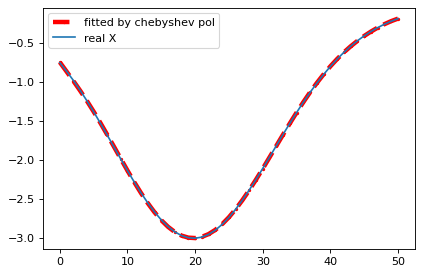

In [94]:
X_parametr_pol_e = chebyshev_approx(X_e,n)
print("Shape of experimental data", X_parametr_pol_e.shape)

0.08361610000000001


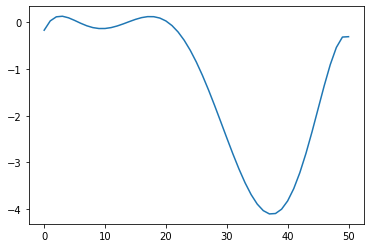

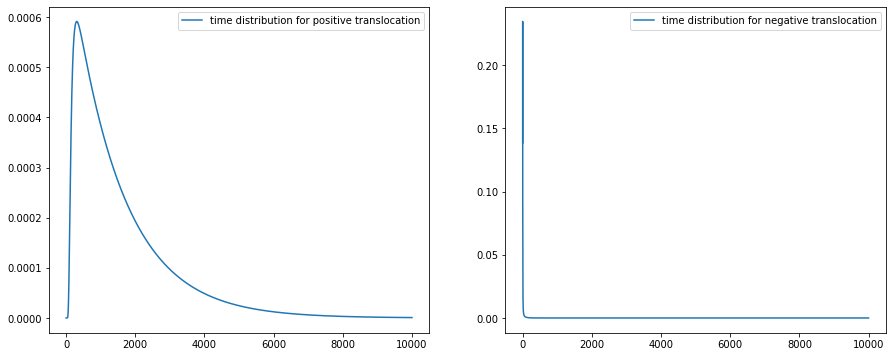

In [96]:
#import function to find time distribution for the free enregy landscape

from probabilities_from_init_distributions import probabilities_from_init_distributions

Y_pos_real, Y_neg_real, rate_real =  probabilities_from_init_distributions (X_parametr_pol_e[8])
print(rate_real)
fig, axes = plt.subplots(1, 2)
axes[0].plot(Y_pos_real, label = 'time distribution for positive translocation')
axes[0].legend()
axes[1].plot(Y_neg_real, label = 'time distribution for negative translocation')
axes[1].legend()

fig.set_figwidth(15)    #  ширина и
fig.set_figheight(6)  

plt.show()

## Initial data

Parametrizing initial distributions (polynomial of 4 degree) - 360 initial data

### Parametrizing initial distributions (by $\textbf{Chebyshev polynomial}$ of 4 degree) - 600 initial data

In [97]:
X1 = pd.read_csv('initial_data.csv').set_index('Unnamed: 0')
X2 = pd.read_csv('initial_data(1).csv').set_index('Unnamed: 0')
X3 = pd.read_csv('initial_data(2).csv').set_index('Unnamed: 0')
X = pd.concat((X1,X2), axis = 0)
X = pd.concat((X,X3), axis = 0)
print("Initial dataset shape", X.shape)

Initial dataset shape (360, 51)


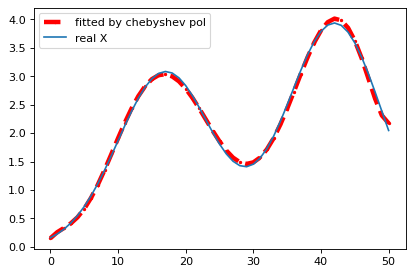

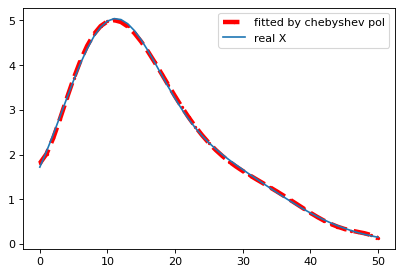

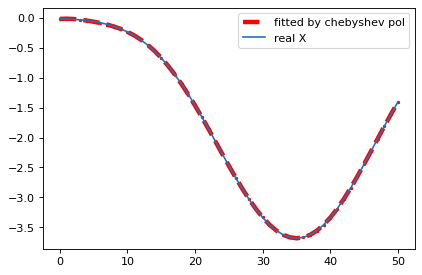

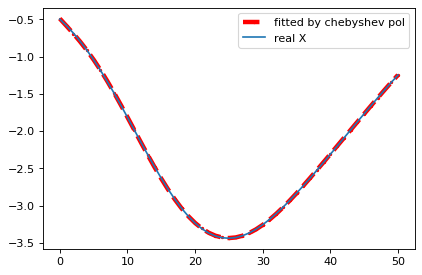

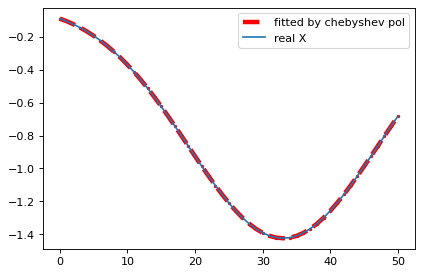

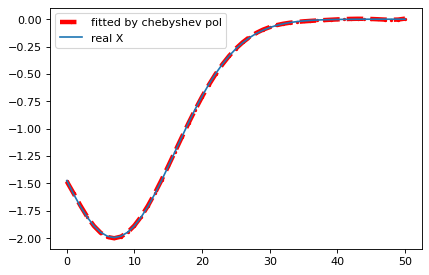

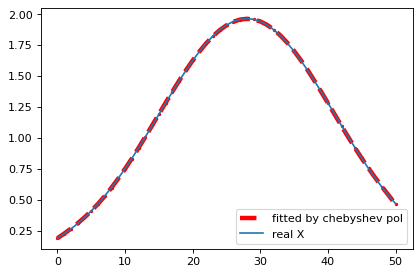

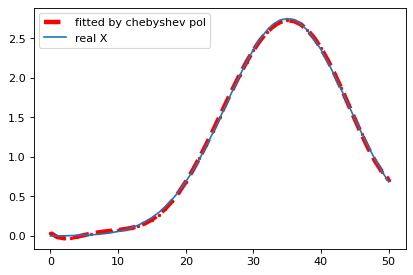

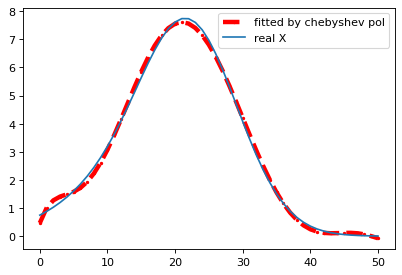

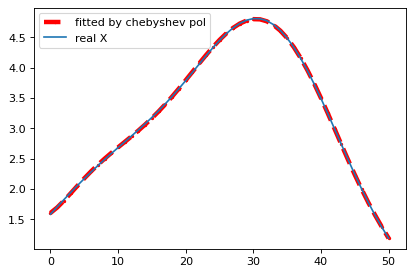

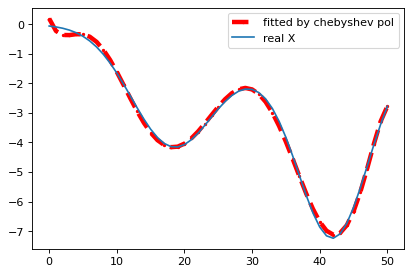

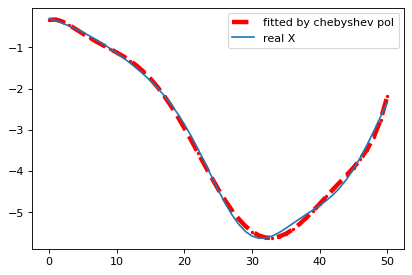

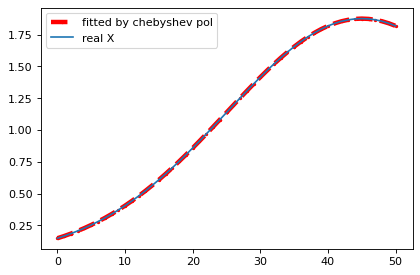

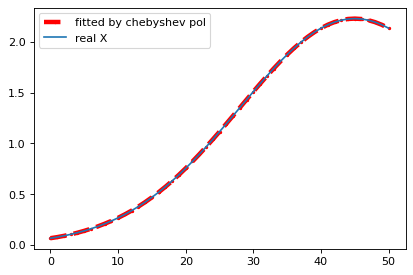

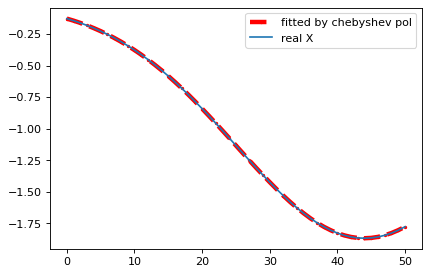

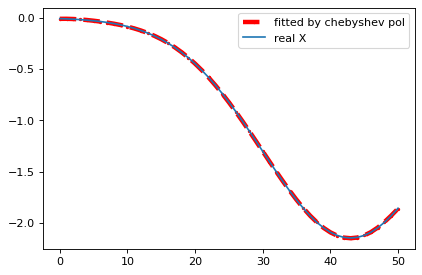

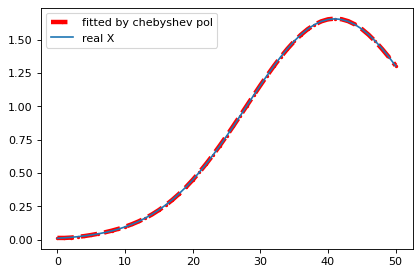

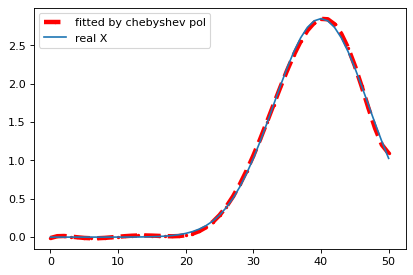

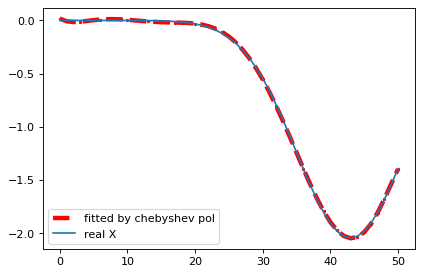

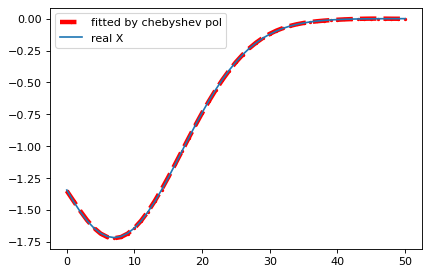

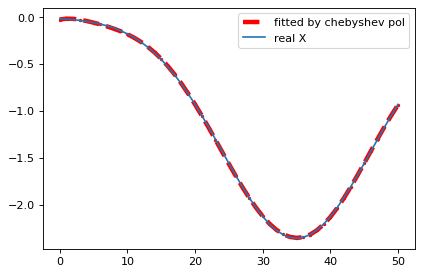

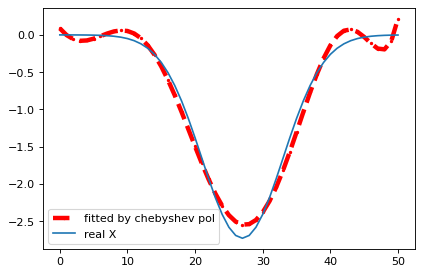

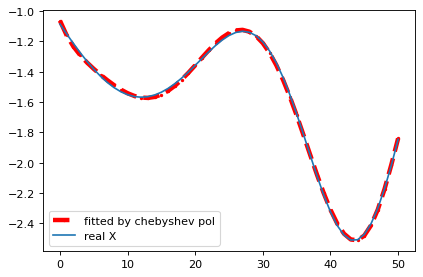

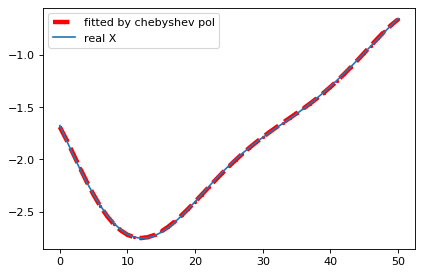

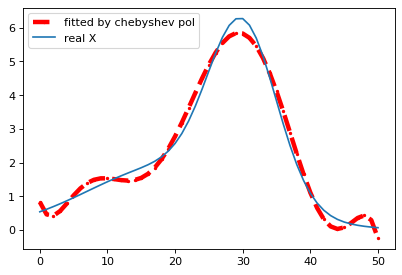

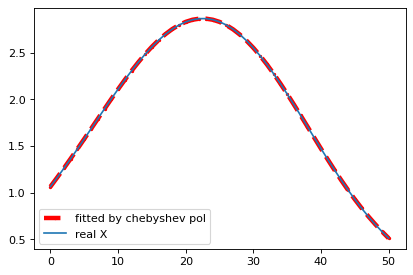

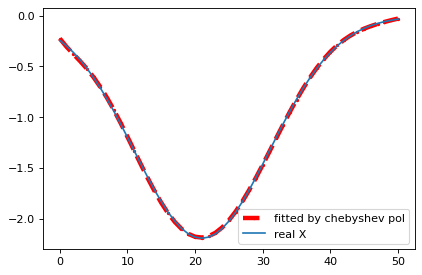

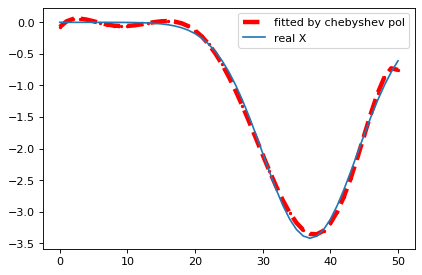

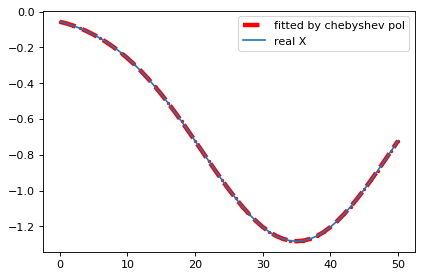

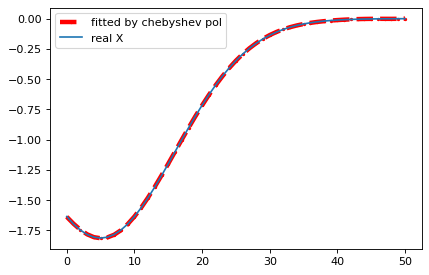

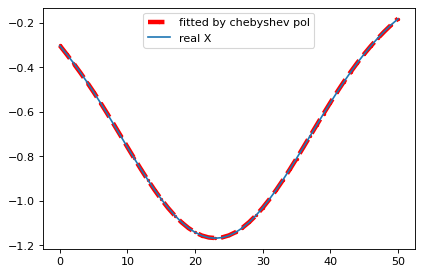

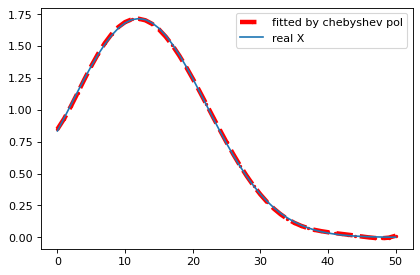

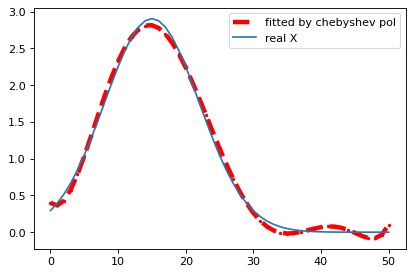

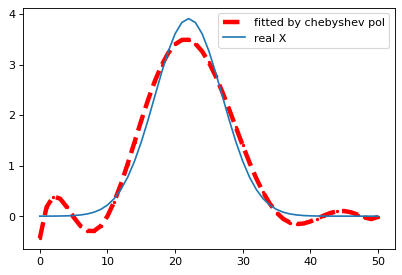

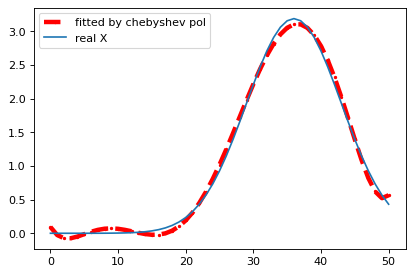

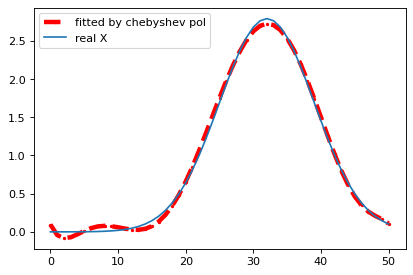

In [98]:
import pandas as pd
import numpy.polynomial.chebyshev as cheb
import numpy as np
X = np.array(X)
X_parametr_pol = chebyshev_approx(X,n)

## Constructing function for optimization

In [99]:
import subprocess
subprocess.call(["gfortran","-o","outputic","F.f90"]) #just for compile the programm

def Fokker_plank_eq (x_end):

    #dat2 = pd.read_csv('./try_to_estim_res1.txt', sep=' ',nrows=1, header=None)
    #rate_real = float(dat2[11])
    #saving new input data
    N = 51
    t = 1
    num1 = 50000
    f = open('./new_input.txt', 'w')
    f.write(str(N-1) + '\t'+ str(t) + '\n' + str(num1)+ '\t'+ str(t) +'\t' + str(10000)+ '\t'+ str(t) + '\n' )
    x = []
    y = []
    for i in range (N-1):
         
          f.write(str(i) + '\t' + str(real(np.polynomial.chebyshev.chebval(i,np.array(x_end)[0]))) + '\n')
    f.write (str(50) + '\t' + str(np.polynomial.chebyshev.chebval(51,np.array(x_end[0]))))
    f.close()

    plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),np.array(x_end)[0]))

    #fortran programm - making new distributions
    subprocess.check_output(["./outputic"])
    #saving new output data
    dat = pd.read_csv('./new_output.txt', sep=' ',skiprows=[0,1,2], header=None)
    dat.drop(dat.columns[0], axis = 1, inplace = True)
    dat.fillna(1e+20, inplace = True)
    r = pd.read_csv('./new_output.txt', sep=' ',nrows=1, header=None)
    r.fillna(1e+20, inplace = True)
    rate = np.array(r)[0][11]
    rate=  float(rate)
    #if str(rate).find('E')==0:
    #  rate = float(str(rate).split('-')[0]) + 'E' + '-' + (str(rate).split('-')[1])

    rate = float(rate)

    Y_pos_new = np.array(dat[1][:], dtype = float)
    Y_neg_new = np.array(dat[2][:], dtype = float)
        

    # mse for minimization
    loss_true = mse((Y_pos_new[:]),(Y_pos_real[:]))
    loss_false = mse((Y_neg_new[:]),(Y_neg_real[:]))
    #loss_false *= 10**(-int(math.log((2*loss_false)/(loss_true),10)))
    loss_rate = abs(rate - rate_real)
    loss_rate *= 10**(-int(math.log((2*loss_rate)/(loss_true + loss_false),10)))
    #print('f',loss_rate,loss_true, loss_rate)
    diff_new = loss_false + loss_true + loss_rate
    #diff_new *= 10**(-int(math.log((diff_new)/(1),10)))
    return diff_new

## BO optimization

In [100]:
#bounds for our function

space =[{'name': 'var_1', 'type': 'continuous', 'domain': (-1,1)},
        {'name': 'var_2', 'type': 'continuous', 'domain': (-1,1)}, #2
        {'name': 'var_3', 'type': 'continuous', 'domain': (-1,1)}, #3
        {'name': 'var_4', 'type': 'continuous', 'domain': (-1,1)}, #5
        {'name': 'var_5', 'type': 'continuous', 'domain': (-1,1)},
        {'name': 'var_6', 'type': 'continuous', 'domain': (-1,1)},
        {'name': 'var_7', 'type': 'continuous', 'domain': (-1,1)},
        {'name': 'var_8', 'type': 'continuous', 'domain': (-1,1)}]

Using a model defined by the used.
105.05201209400093


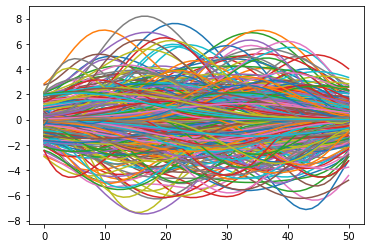

In [87]:
seed(123456)
from time import perf_counter
# BO object
import math
kernel = GPy.kern.RBF(n+1, 1.5, 2)*GPy.kern.Matern52(input_dim = n+1) + GPy.kern.Bias(input_dim=n+1)

kernel.randomize()
model = GPyOpt.models.GPModel(optimize_restarts=2, kernel = kernel, exact_feval = True) #GP model without noize and with 3 restarts
#model.model = m
t1_start = perf_counter()  
myBopt = GPyOpt.methods.BayesianOptimization(f = Fokker_plank_eq,        # function to optimize       
                                            # model_update_interval = 3,
                                           #  evaluator_type = "local_penalization",
                                          #   batch_size = 5,
                                             domain = space,        # box-constraints of the problem
                                             model_type='InputWarpedGP',
                                             model = model,
                                             X = X_parametr_pol, 
                                             normalize_Y = True,
                                             verbosity = True,
                                             acquisition_type ='MPI') # acquisition = Expected improvement

t1_stop = perf_counter()
print(t1_stop - t1_start)                          

Optimization restart 1/2, f = 344.4773332034502
Optimization restart 2/2, f = 344.4773390986338
Optimization restart 1/2, f = 341.5209038328949
Optimization restart 2/2, f = 341.52089981641586
Optimization restart 1/2, f = 338.79376334300144
Optimization restart 2/2, f = 338.79381902269796
Optimization restart 1/2, f = 336.26349323829993
Optimization restart 2/2, f = 336.26351375196845
Optimization restart 1/2, f = -2012.561892064408
Optimization restart 2/2, f = -2012.6512348894273
Optimization restart 1/2, f = -1995.4759703052334
Optimization restart 2/2, f = -1995.8128620872976
Optimization restart 1/2, f = -1984.5308238215337
Optimization restart 2/2, f = -1989.6794307428156
Optimization restart 1/2, f = -1980.2345994800978
Optimization restart 2/2, f = -1976.4339339264009
Optimization restart 1/2, f = -1973.2781425008507
Optimization restart 2/2, f = -1973.6536984260772
Optimization restart 1/2, f = -1967.692938741901
Optimization restart 2/2, f = -1967.4571921636013
Optimization 

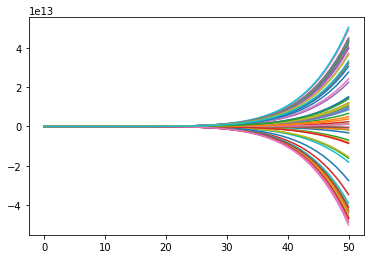

In [88]:
t1_start = perf_counter()
myBopt.run_optimization(70)
t1_stop = perf_counter()
print(t1_stop - t1_start) 

### Many-many experiments

Predicted params 
 [-3.43324469e-01  6.17752473e-01 -1.20234937e-01  8.52576610e-03
 -2.58173099e-04  3.81715953e-06 -2.73483920e-08  7.61112473e-11]
Real params 
 [-2.42693006e-01  4.77669412e-01 -9.49614930e-02  7.25829537e-03
 -2.35424643e-04  3.70589913e-06 -2.80836978e-08  8.21135781e-11]


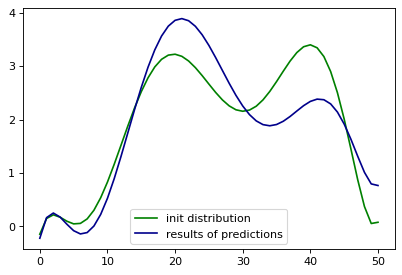

In [61]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),hills), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',hills)

Predicted params 
 [-1.62705673e-01  1.87259174e-01 -3.17743676e-02  1.91675236e-03
 -5.54472170e-05  7.69193317e-07 -4.96158986e-09  1.19505984e-11]
Real params 
 [-2.04872616e-01  2.76446883e-01 -3.93215002e-02  2.05554402e-03
 -4.65475377e-05  4.47834968e-07 -1.40308593e-09 -1.10686906e-12]


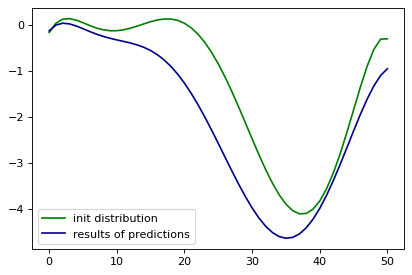

In [33]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[8]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[8])

Predicted params 
 [ 3.80570041e-02  5.16110468e-03  3.14102343e-04 -4.33284001e-06
  2.73223872e-07 -3.85004218e-09  1.45122680e-11  1.29205563e-15]
Real params 
 [ 7.00247782e-02 -1.24593742e-02  1.60815465e-03 -3.28225475e-05
 -1.11931294e-06  5.30467180e-08 -6.64011006e-10  2.64005115e-12]


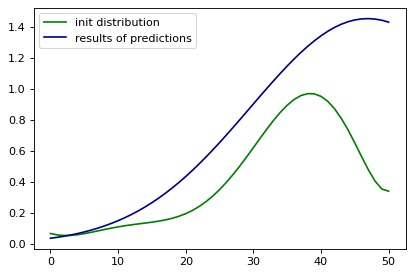

In [27]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[7]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[7])

Predicted params 
 [-5.85554671e-01  8.99116148e-01 -1.48649523e-01  9.09031884e-03
 -2.46937726e-04  3.32522630e-06 -2.18838823e-08  5.63270393e-11]
Real params 
 [-1.14355207e+00  8.92442119e-01 -1.49523450e-01  7.45068188e-03
 -1.70415657e-04  2.01097596e-06 -1.19400628e-08  2.82926800e-11]


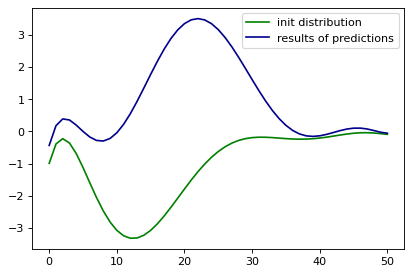

In [21]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[6]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[6])

Predicted params 
 [-3.96740317e-01 -5.53201817e-02 -1.41363630e-04 -6.38231043e-05
  2.20623457e-06 -2.22762989e-08  7.27983625e-11  6.74667987e-25]
Real params 
 [-1.23469775e+00 -6.06550984e-02 -6.48694124e-03  4.69605416e-04
 -1.24603618e-05  1.45990593e-07 -7.27885659e-10  1.13942379e-12]


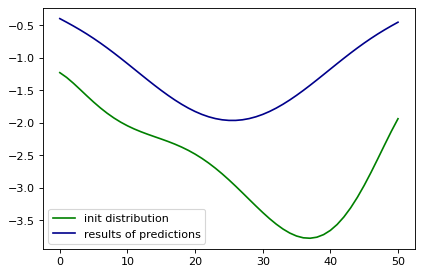

In [56]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[5]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[5])

Predicted params 
 [ 1.06505604e+00  9.54041106e-02  4.56023487e-04  1.46214883e-05
 -1.25660203e-06  1.34721517e-08 -3.03349063e-11 -8.41223665e-14]
Real params 
 [ 1.54909921e+00  9.56115985e-02  2.15319321e-03 -2.26458049e-04
  7.95935317e-06 -1.28986724e-07  9.44814120e-10 -2.55937784e-12]


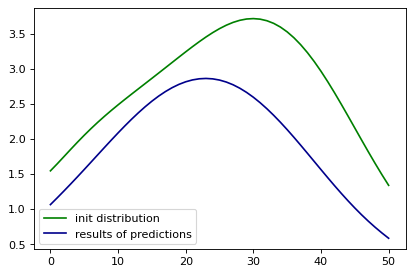

In [51]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[4]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[4])

Predicted params 
 [-3.57162912e-01 -1.06302558e-01  3.59453619e-03 -6.89576136e-04
  2.91195832e-05 -4.84155631e-07  3.59652159e-09 -1.00193649e-11]
Real params 
 [-7.47744177e-01 -1.19378116e-01  1.25200942e-03 -2.73809079e-04
  1.15978176e-05 -1.79769715e-07  1.22421902e-09 -3.12022457e-12]


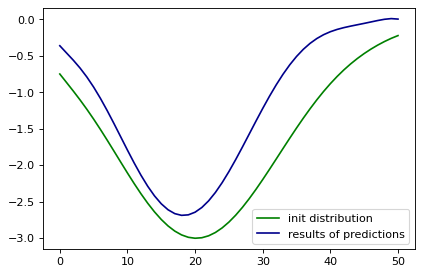

In [34]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[0]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[0])

Predicted params 
 [ 1.83209789e+00  1.89781034e-01 -1.42745482e-02  6.94173423e-04
 -1.66576059e-05  1.87557356e-07 -9.52137707e-10  1.68339766e-12]
Real params 
 [ 1.09513698e+00  2.11332250e-01 -1.87853725e-02  1.61184050e-03
 -5.41858513e-05  8.17071299e-07 -5.73664048e-09  1.53723244e-11]


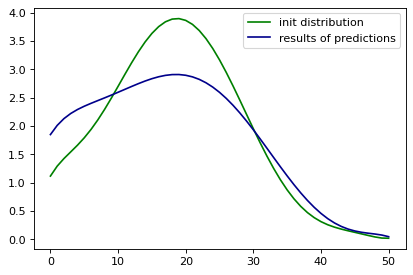

In [29]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[1]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[1])

Predicted params 
 [ 1.64171311e+00  9.45254839e-02  3.04486627e-02 -2.18163829e-03
  5.49195874e-05 -6.64682127e-07  3.94158223e-09 -9.22299397e-12]
Real params 
 [ 7.17234188e-01 -1.68136119e-01  7.05164608e-02 -4.27578874e-03
  1.07848094e-04 -1.35978046e-06  8.51143806e-09 -2.11240142e-11]


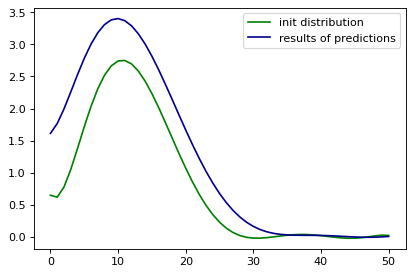

In [40]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[2]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[2])

Predicted params 
 [ 3.95836619e-01 -8.29368186e-02  1.51181947e-02 -4.00846199e-04
  3.77019760e-06 -1.19718775e-08]
Real params 
 [ 1.41910833e+00 -1.55700982e-01  2.84952056e-02 -8.49183649e-04
  8.96758770e-06 -3.19688983e-08]


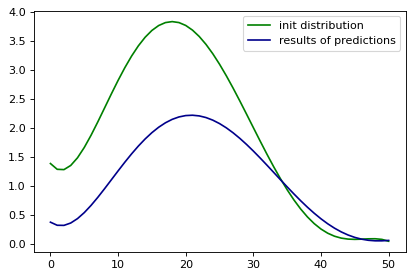

In [38]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[1]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[1])

Predicted params 
 [ 5.22359463e-02 -1.47852533e-01  2.19624647e-02 -1.50426740e-03
  4.05340069e-05 -5.08296870e-07  3.00899177e-09 -6.80132428e-12]
Real params 
 [-7.47744177e-01 -1.19378116e-01  1.25200942e-03 -2.73809079e-04
  1.15978176e-05 -1.79769715e-07  1.22421902e-09 -3.12022457e-12]


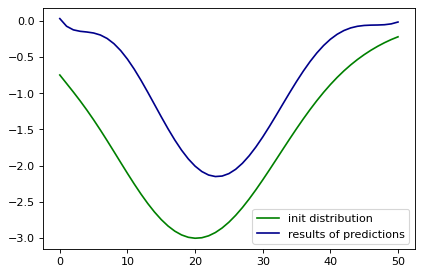

In [227]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[0]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[0])

Predicted params 
 [-7.19844497e-02 -2.42434349e-02 -3.47357689e-04 -1.42344967e-05
 -2.58973700e-06  8.74819571e-08 -8.98197390e-10  3.01675996e-12]
Real params 
 [-2.66382255e-02  4.53077324e-02 -1.01723468e-02  8.22668629e-04
 -3.15617557e-05  5.52354769e-07 -4.39672371e-09  1.30361901e-11]


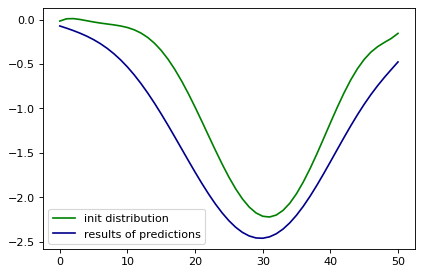

In [101]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[3]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[3])

Predicted params 
 [-7.52185161e-01  1.02923850e-01 -4.77715887e-02  2.35724671e-03
 -4.84256160e-05  4.87785752e-07 -2.33490383e-09  4.09559993e-12]
Real params 
 [-1.14355207e+00  8.92442119e-01 -1.49523450e-01  7.45068188e-03
 -1.70415657e-04  2.01097596e-06 -1.19400628e-08  2.82926800e-11]


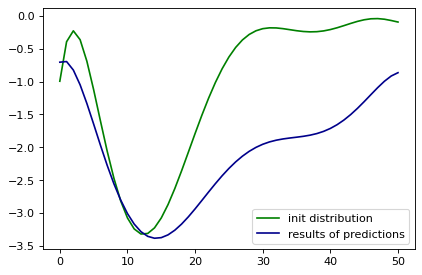

In [207]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[6]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[6])

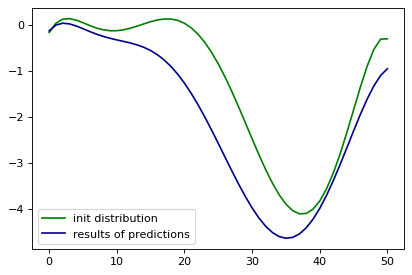

In [102]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[8]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()